# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.615341,False,-0.216582
1,1.547448,True,3.791882
2,-1.220144,True,4.319986
3,-0.167506,True,6.049082
4,2.950866,True,4.455041
...,...,...,...
995,0.978907,True,6.964400
996,2.768105,True,4.851054
997,0.657292,True,7.053682
998,0.462598,False,0.075282


<AxesSubplot: xlabel='v0'>

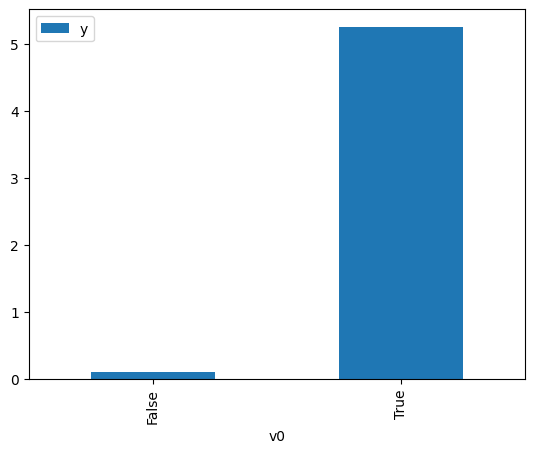

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

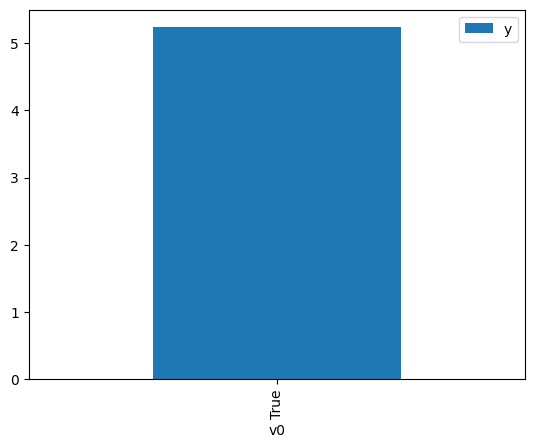

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.067560,False,1.911379,0.466482,2.143707
1,0.823216,False,-1.139482,0.298868,3.345962
2,1.662468,False,0.487500,0.161029,6.210075
3,1.219407,False,-0.734138,0.226293,4.419058
4,3.170608,False,0.352740,0.043754,22.854844
...,...,...,...,...,...
995,2.290390,False,0.137876,0.095559,10.464770
996,1.037646,False,0.709049,0.257967,3.876460
997,-0.134015,False,1.177118,0.514338,1.944246
998,0.438583,False,-2.028024,0.380597,2.627451


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.151752,True,5.144520,0.553375,1.807092
1,-0.361275,True,5.457729,0.432065,2.314466
2,-0.516995,True,4.685548,0.396163,2.524211
3,-0.151791,True,7.376667,0.481441,2.077096
4,0.533555,True,4.762663,0.640448,1.561408
...,...,...,...,...,...
995,2.328699,True,5.015506,0.907543,1.101876
996,0.922553,True,6.789926,0.720539,1.387849
997,0.890339,True,5.813846,0.714331,1.399912
998,-0.380071,True,4.574668,0.427686,2.338166


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              8643.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:38:55   Log-Likelihood:                         -1450.1
No. Observations:                1000   AIC:                                      2904.
Df Residuals:                     998   BIC:                                      2914.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2364      0.035      6.773      0.000       0.168       0.305
x2             5.0849      0.053     95.597      0.000       4.981       5.189
==============================================================================
Omnibus:                        0.226   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.264
Skew:                           0.035   Prob(JB):                        0.876
Kurtosis:                       2.962   Cond. No.                         2.46
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""